# Processing Categorical Features

So far, I've done:

1) Basic exploratory data analysis
2) Tuning my target variable
3) Tuned my numeric features

I just need to tune my categorical features, then I can start modeling.

# Packages and Settings

In [1]:
import pandas as pd 
import numpy as np 

from pathlib import Path
from utils import *

# Import Data

In [2]:
df = pd.read_parquet("data/df_train_numeric.parquet") # final output from prior numeric_features notebook

In [3]:
all_cols = [
  'Area',
  'VehPower',
  'VehAge',
  'DrivAge',
  'BonusMalus',
  'VehBrand',
  'VehGas',
  'Density',
  'Region'
]

num_cols = list(df[all_cols].select_dtypes(include=[np.number]).columns)
cat_cols = list(df[all_cols].select_dtypes(exclude=[np.number]).columns)
print(cat_cols)

['Area', 'VehBrand', 'VehGas', 'Region']


# Area

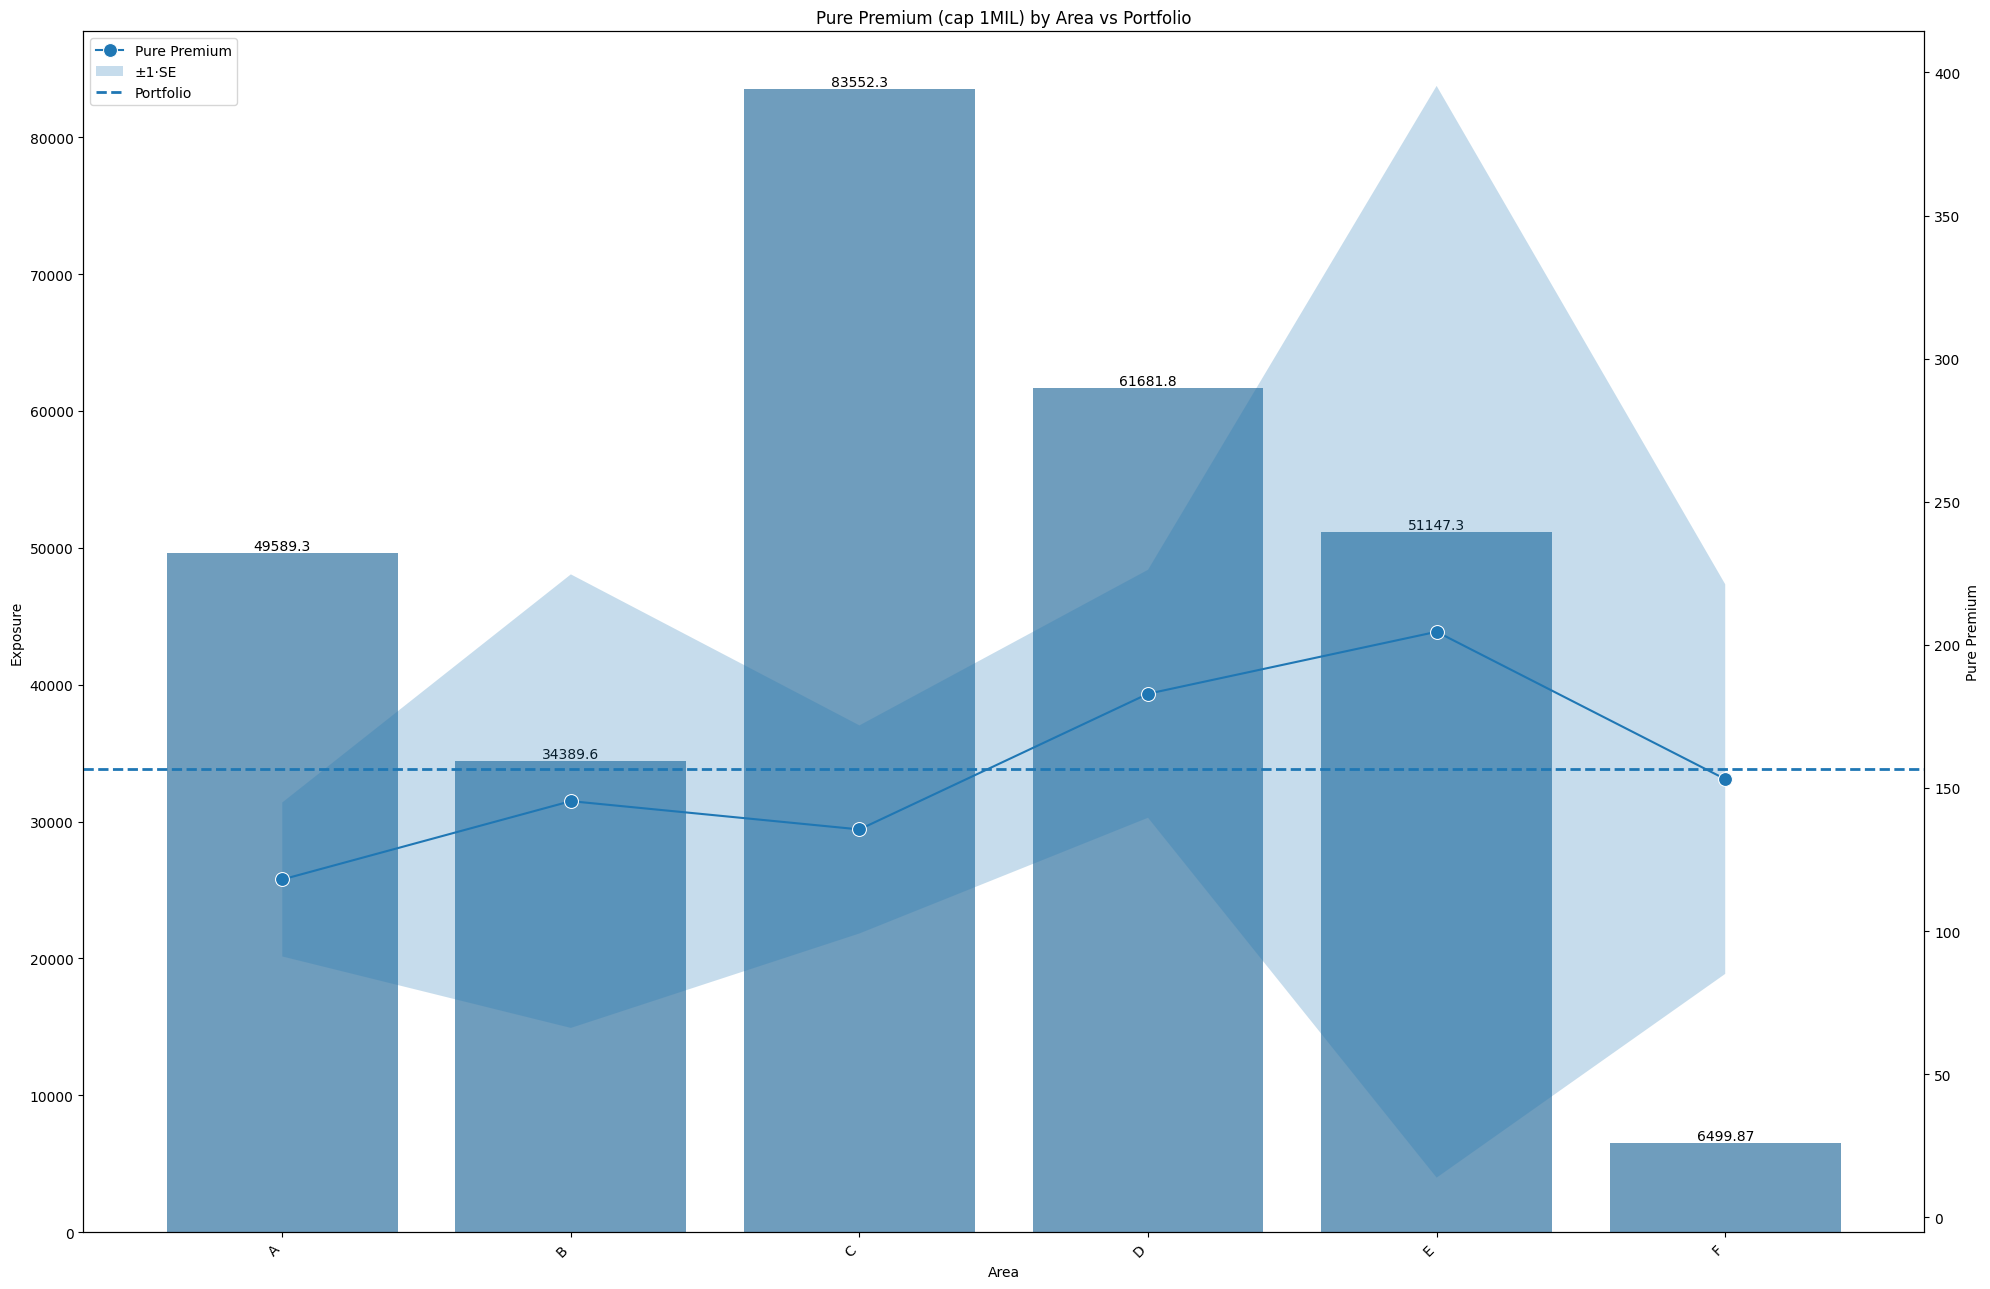

In [4]:
fig = runmultiplot(df, "Area", metric="Pure Premium", cap=1000000)

There are 6 distinct areas. Most of them are populated with a lot of exposures except for Area F. I see that areas A-C have lower than average pure premium while D-E have above average pure premium and region F is right at average. Area E has a really wide variance while the other areas are much closer together.

I'd like to try a couple of binning scenarios:

1) No grouping
2) Group B and F, as they are the closest to the same and also the two smallest categories
3) Group A-C & F and D-E. This is the most reasonable and most aggressive binning scenario I'd feel comfortable with.

In [5]:
df["Area_bin1"] = np.select(
  condlist = [
    df["Area"].isin(["B", "F"])
  ],
  choicelist=[
    "B and F"
  ],
  default=df["Area"]
)
df["Area_bin2"] = np.select(
  condlist = [
    df["Area"].isin(["A", "B", "C", "F"]),
    df["Area"].isin(["D", "E"])
  ],
  choicelist=[
    "A-C and F",
    "D and E"
  ],
  default=df["Area"]
)

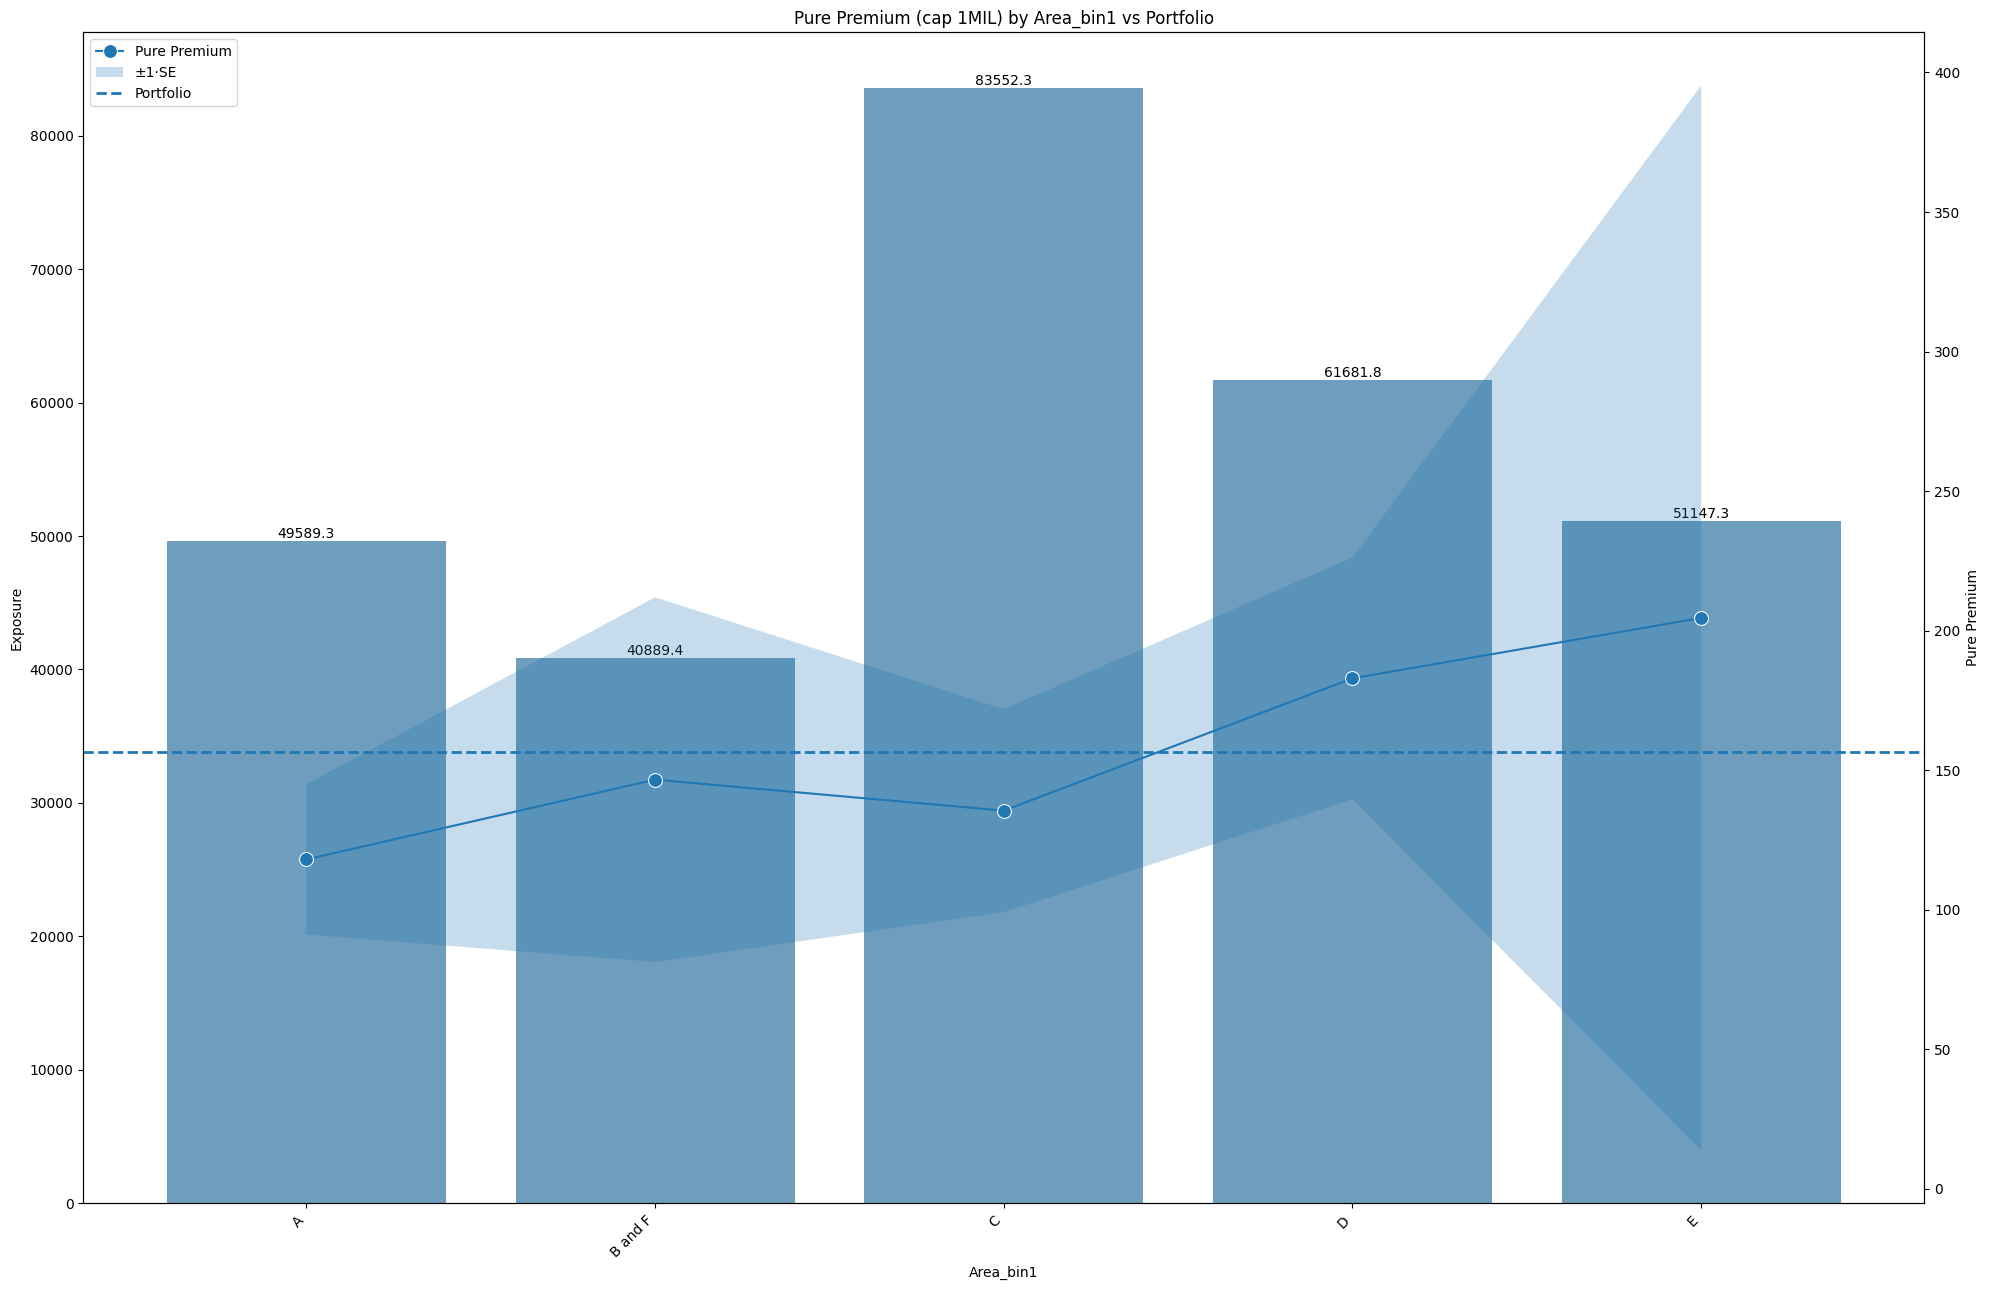

In [6]:
fig = runmultiplot(df, "Area_bin1", metric="Pure Premium", cap=1000000)

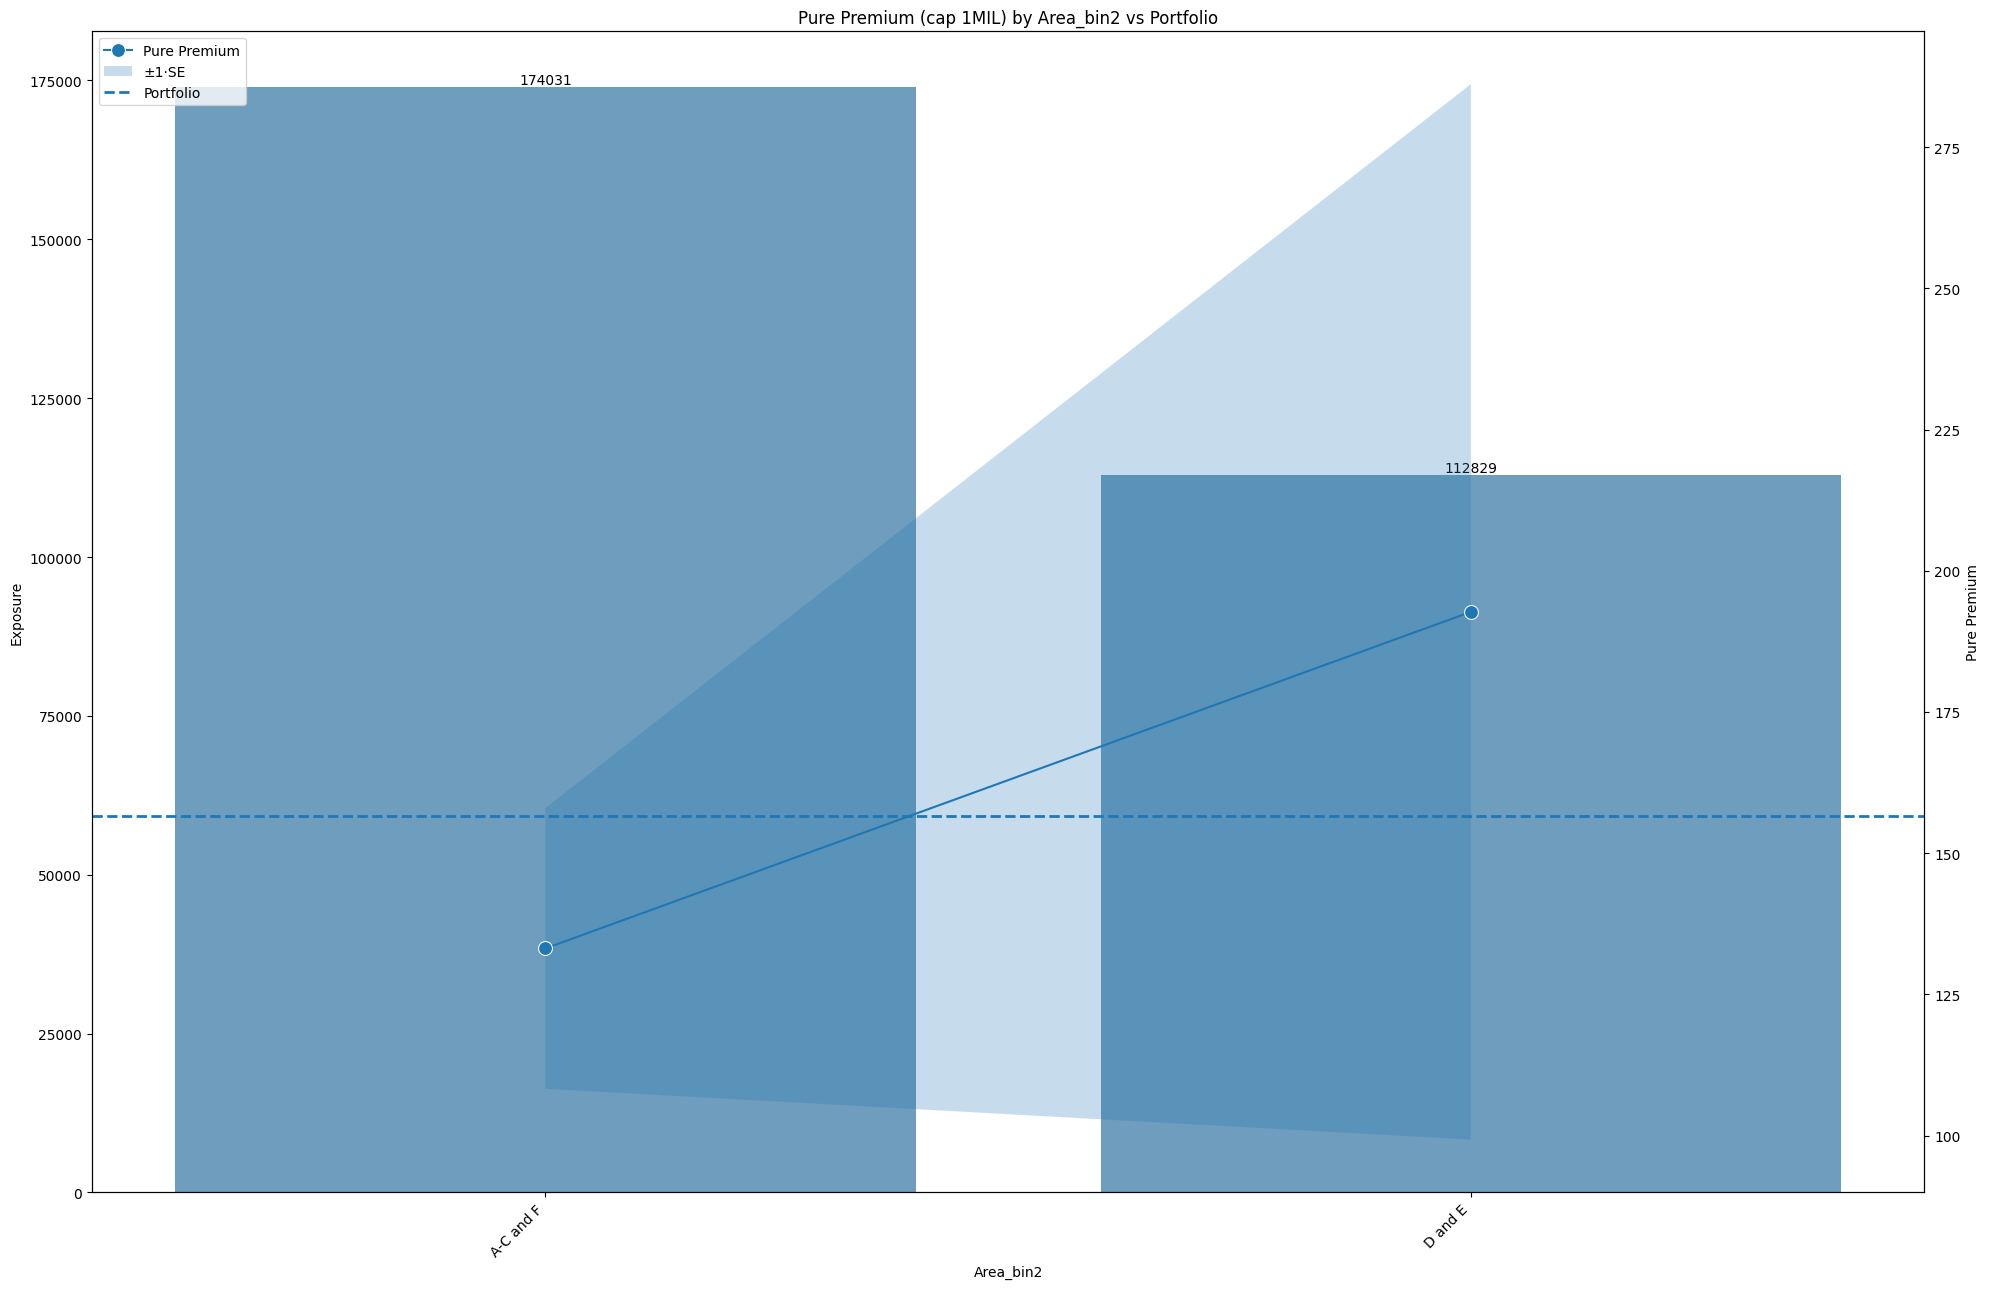

In [7]:
fig = runmultiplot(df, "Area_bin2", metric="Pure Premium", cap=1000000)

# VehBrand

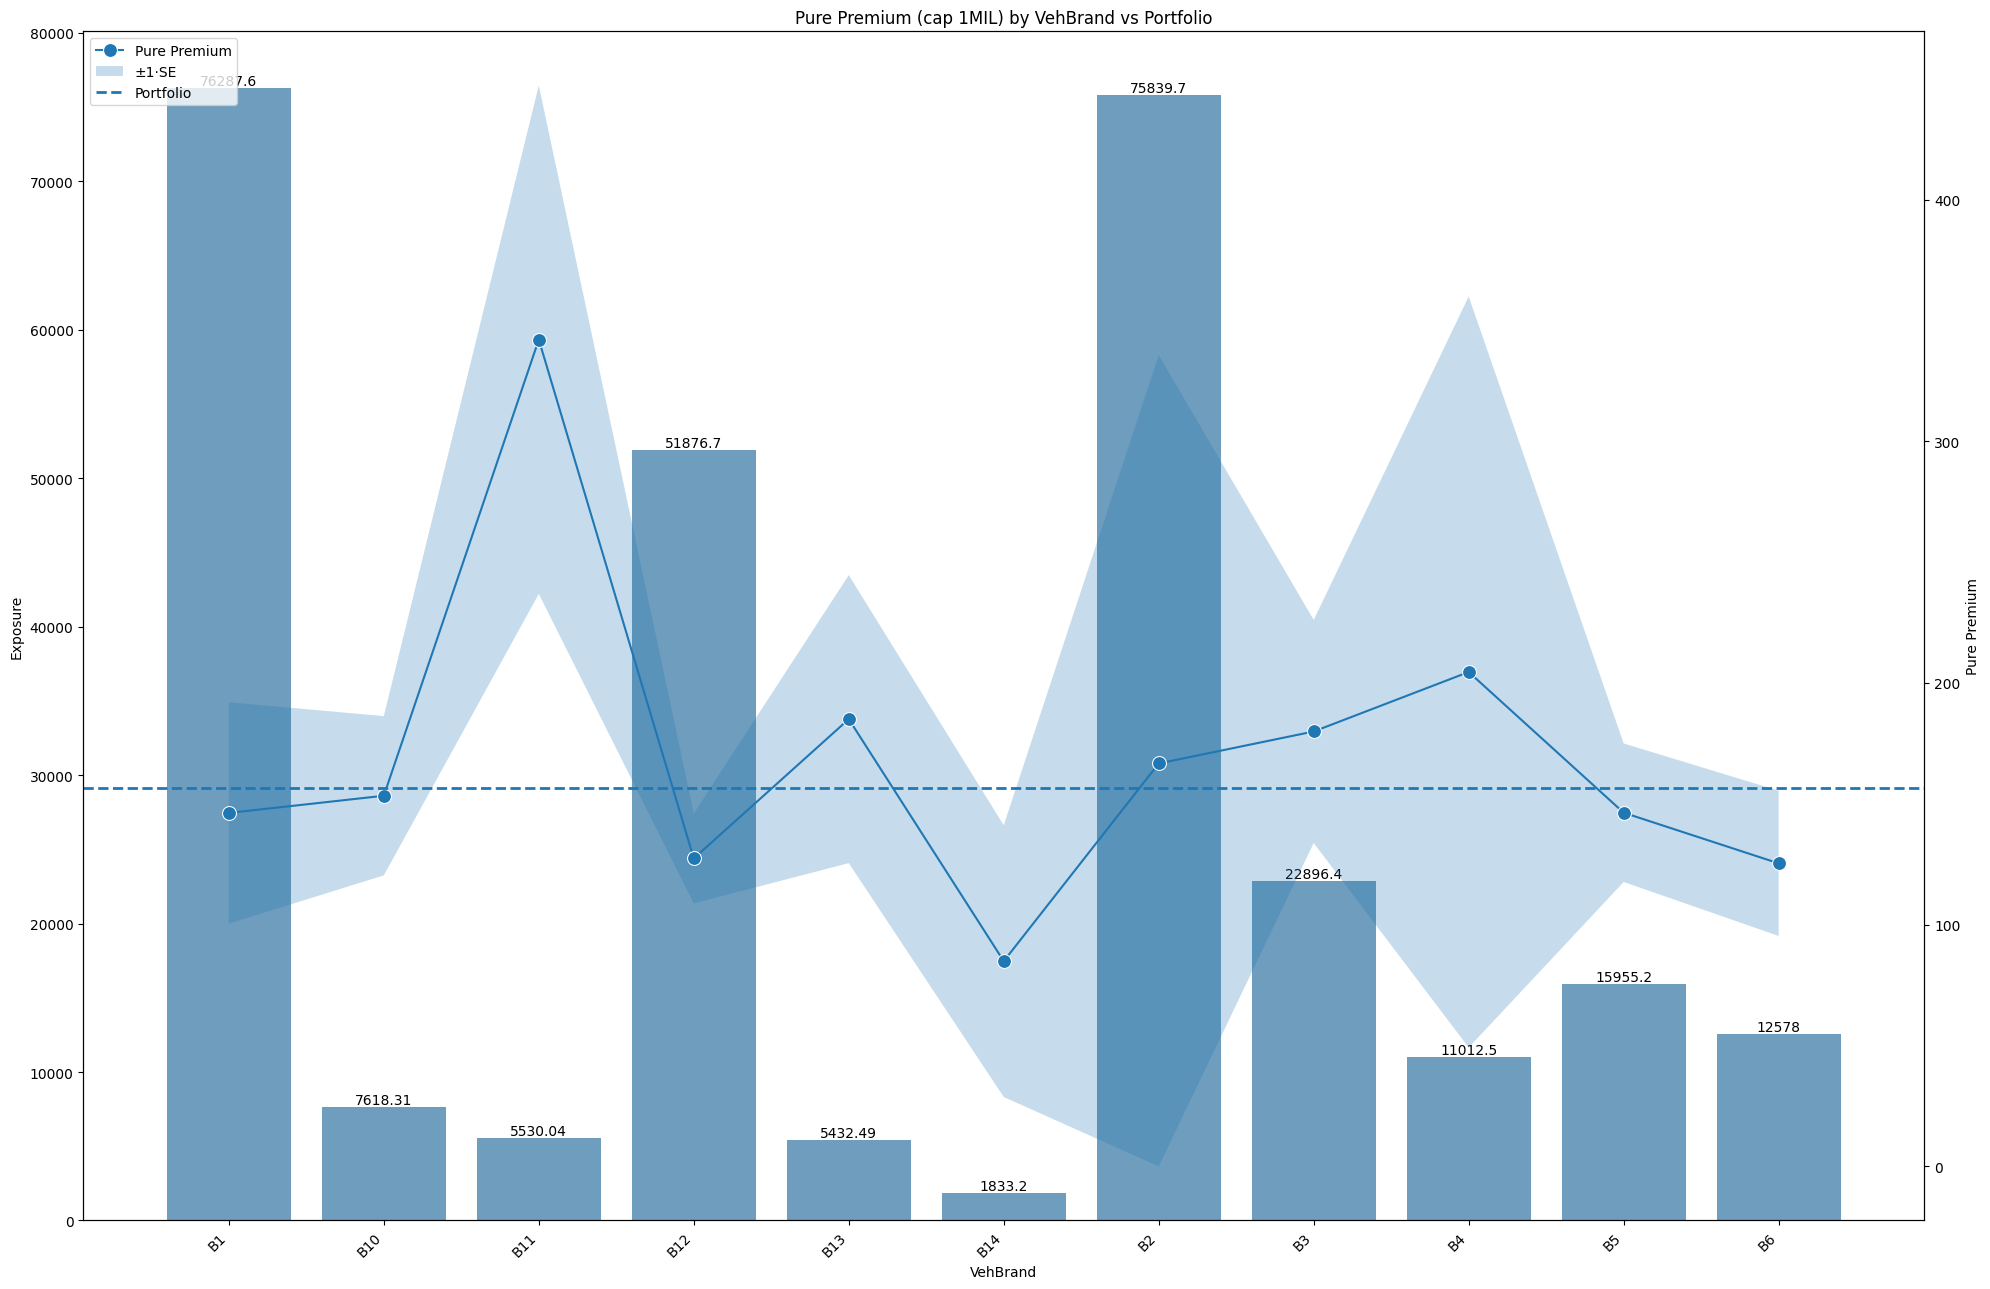

In [8]:
fig = runmultiplot(df, "VehBrand", metric="Pure Premium", cap=1000000)

This one is going to be difficult to group but I don't like keeping it at this granularity because there are a ton of small buckets that are certainly going to be uncredible. Let me reorder this so that I can see what VehBrands are similar to each other on average:

In [9]:
tot_exposure = df["Exposure"].sum()
summary = df.groupby("VehBrand", as_index=False, observed=False).agg(
  exposure = ("Exposure", "sum"),
  loss = ("ClaimAmount_capped_1MIL", "sum"),
  n = ("VehBrand", "size")
)
summary["perc_exposure"] = summary["exposure"] / tot_exposure
summary["pure_premium"] = summary["loss"] / summary["exposure"] 
summary = summary[["VehBrand", "perc_exposure", "pure_premium"]].sort_values("pure_premium").reset_index(drop=True)
summary

,VehBrand,perc_exposure,pure_premium
0,B14,0.006391,84.919060
1,B6,0.043847,125.378906
2,B12,0.180843,127.419524
3,B1,0.265940,146.237347
4,B5,0.055620,146.326141
5,B10,0.026558,153.344059
6,B2,0.264379,166.699976
7,B3,0.079817,179.933991
8,B13,0.018938,185.042434
9,B4,0.038390,204.537974


I'll try the following grouping:

In [10]:
df["VehBrand_bin1"] = np.select(
  condlist=[
    df["VehBrand"].isin(["B14", "B6", "B12"]),
    df["VehBrand"].isin(["B1"]),
    df["VehBrand"].isin(["B5", "B10", "B2"]),
    df["VehBrand"].isin(["B3", "B13", "B4", "B11"])
  ],
  choicelist=[
    "(01): B6, B12, B14",
    "(02): B1",
    "(03): B2, B5, B10",
    "(04): B3, B4, B11, B13"
  ],
  default=df["VehBrand"]
)

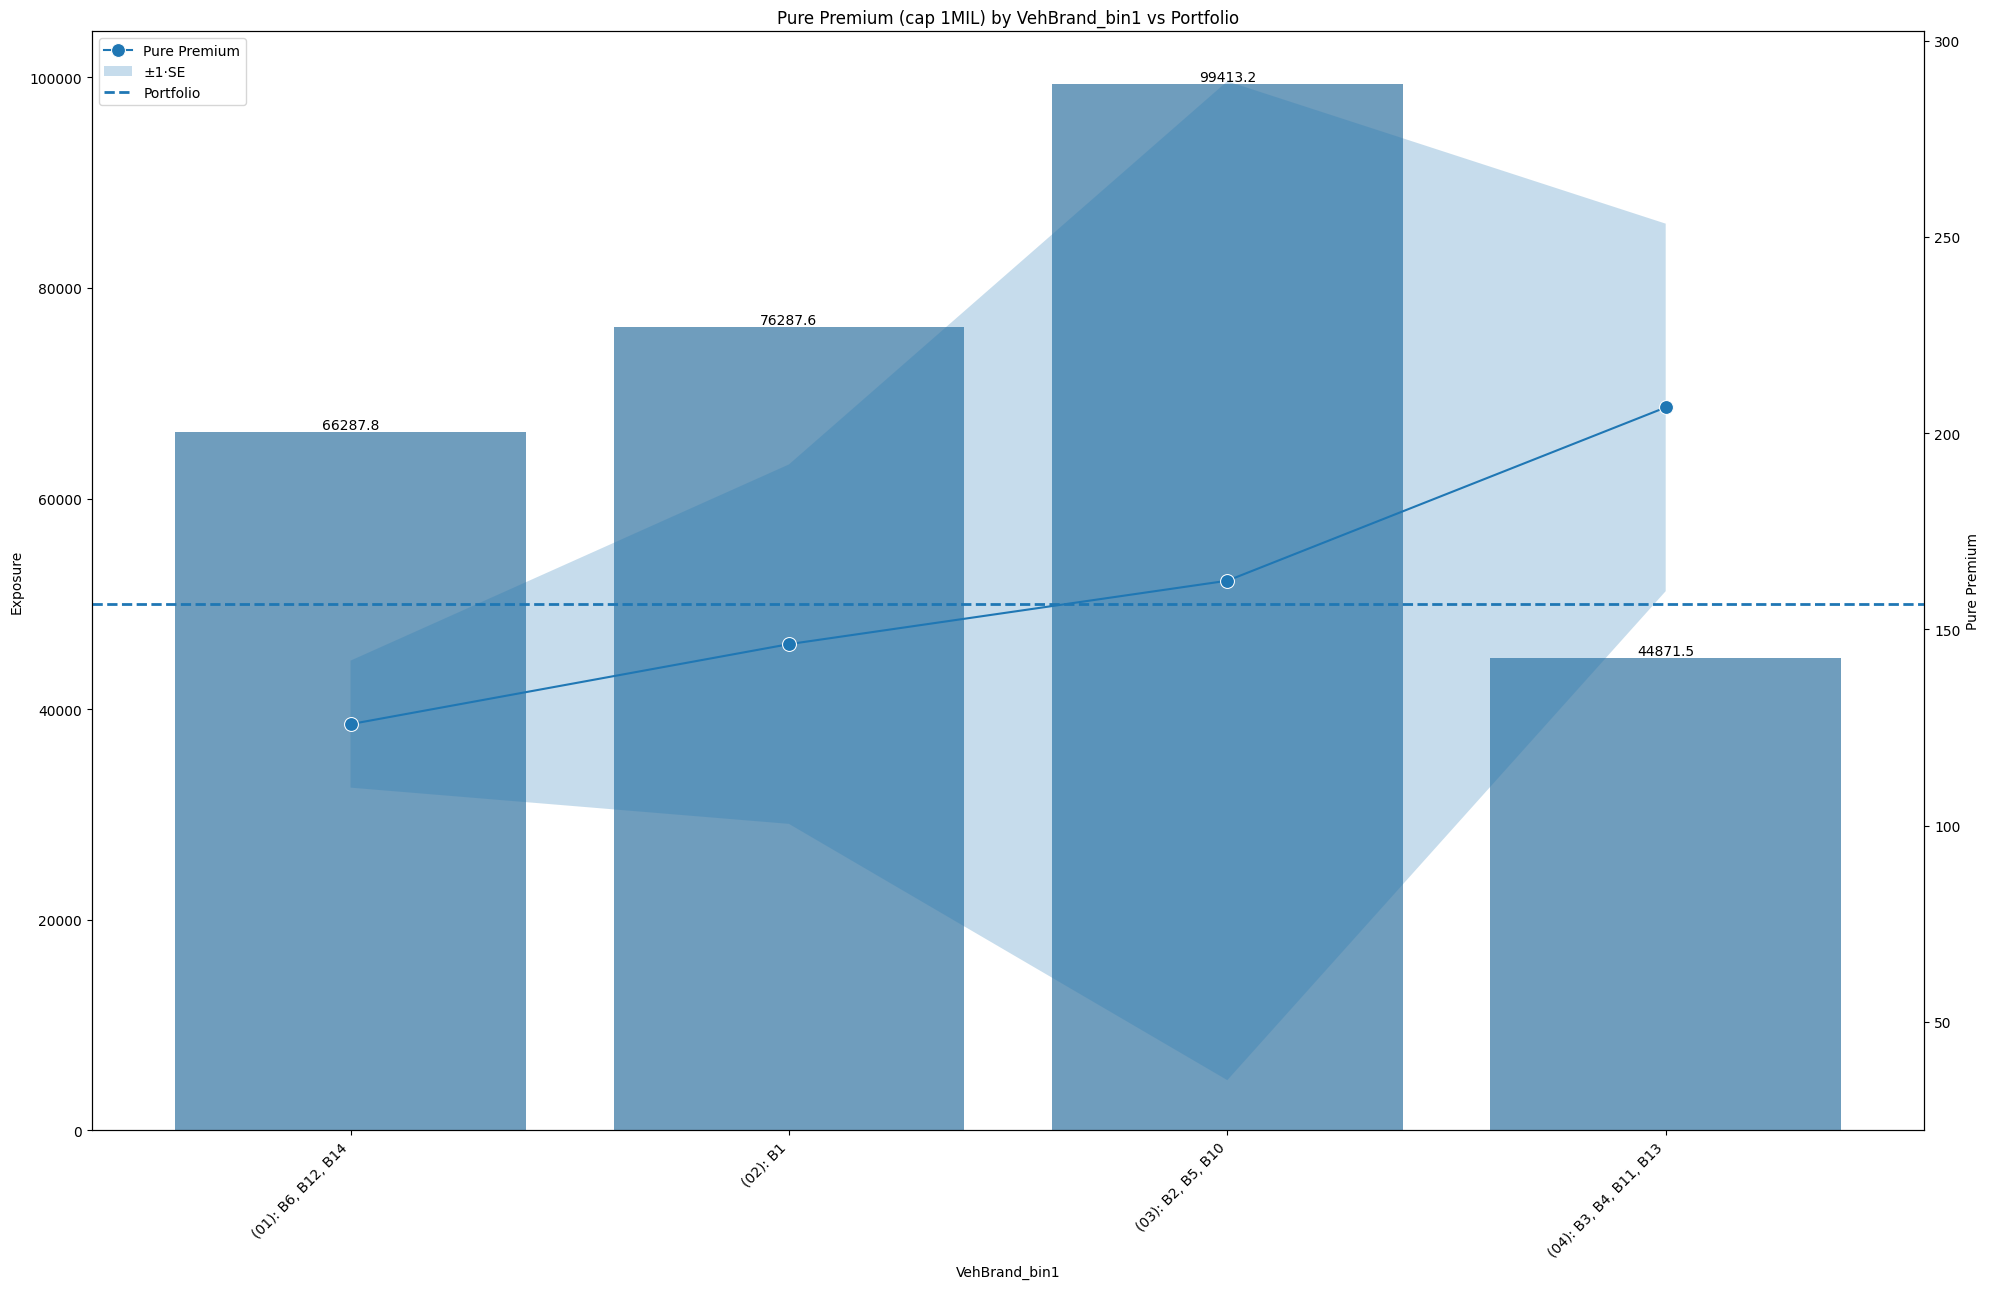

In [11]:
fig = runmultiplot(df, "VehBrand_bin1", metric="Pure Premium", cap=1000000)

Not a terrible grouping, but I could get more granularity out of more specificity. This would be something interesting to play around with and tune better.

# VehGas

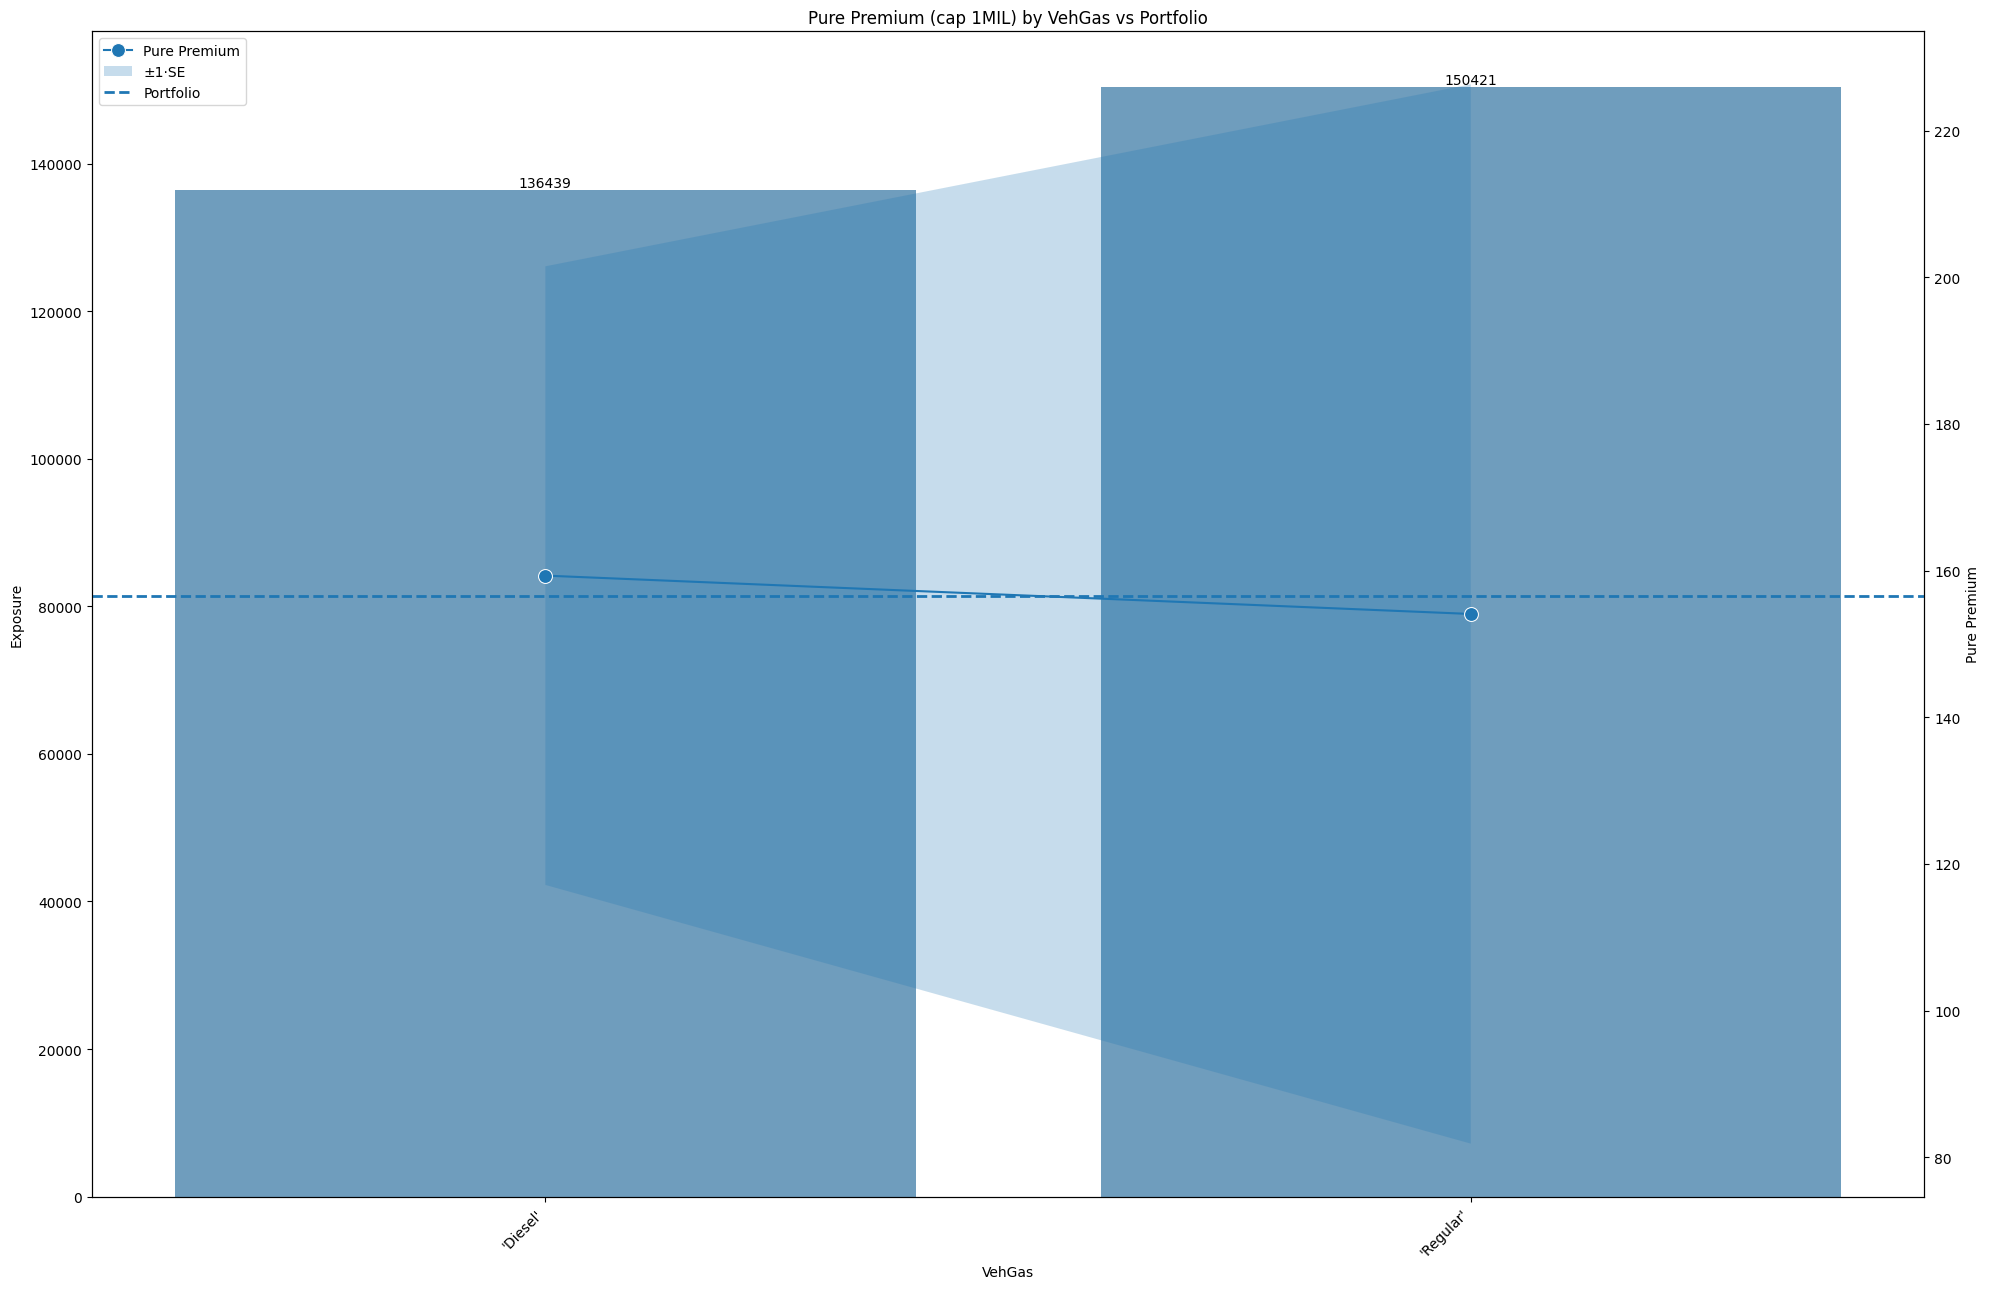

In [12]:
fig = runmultiplot(df, "VehGas", metric="Pure Premium", cap=1000000)

No binning necessary! I'll also note there is not much difference in these two categories. Perhaps there are some interactions that are useful later?

# Region

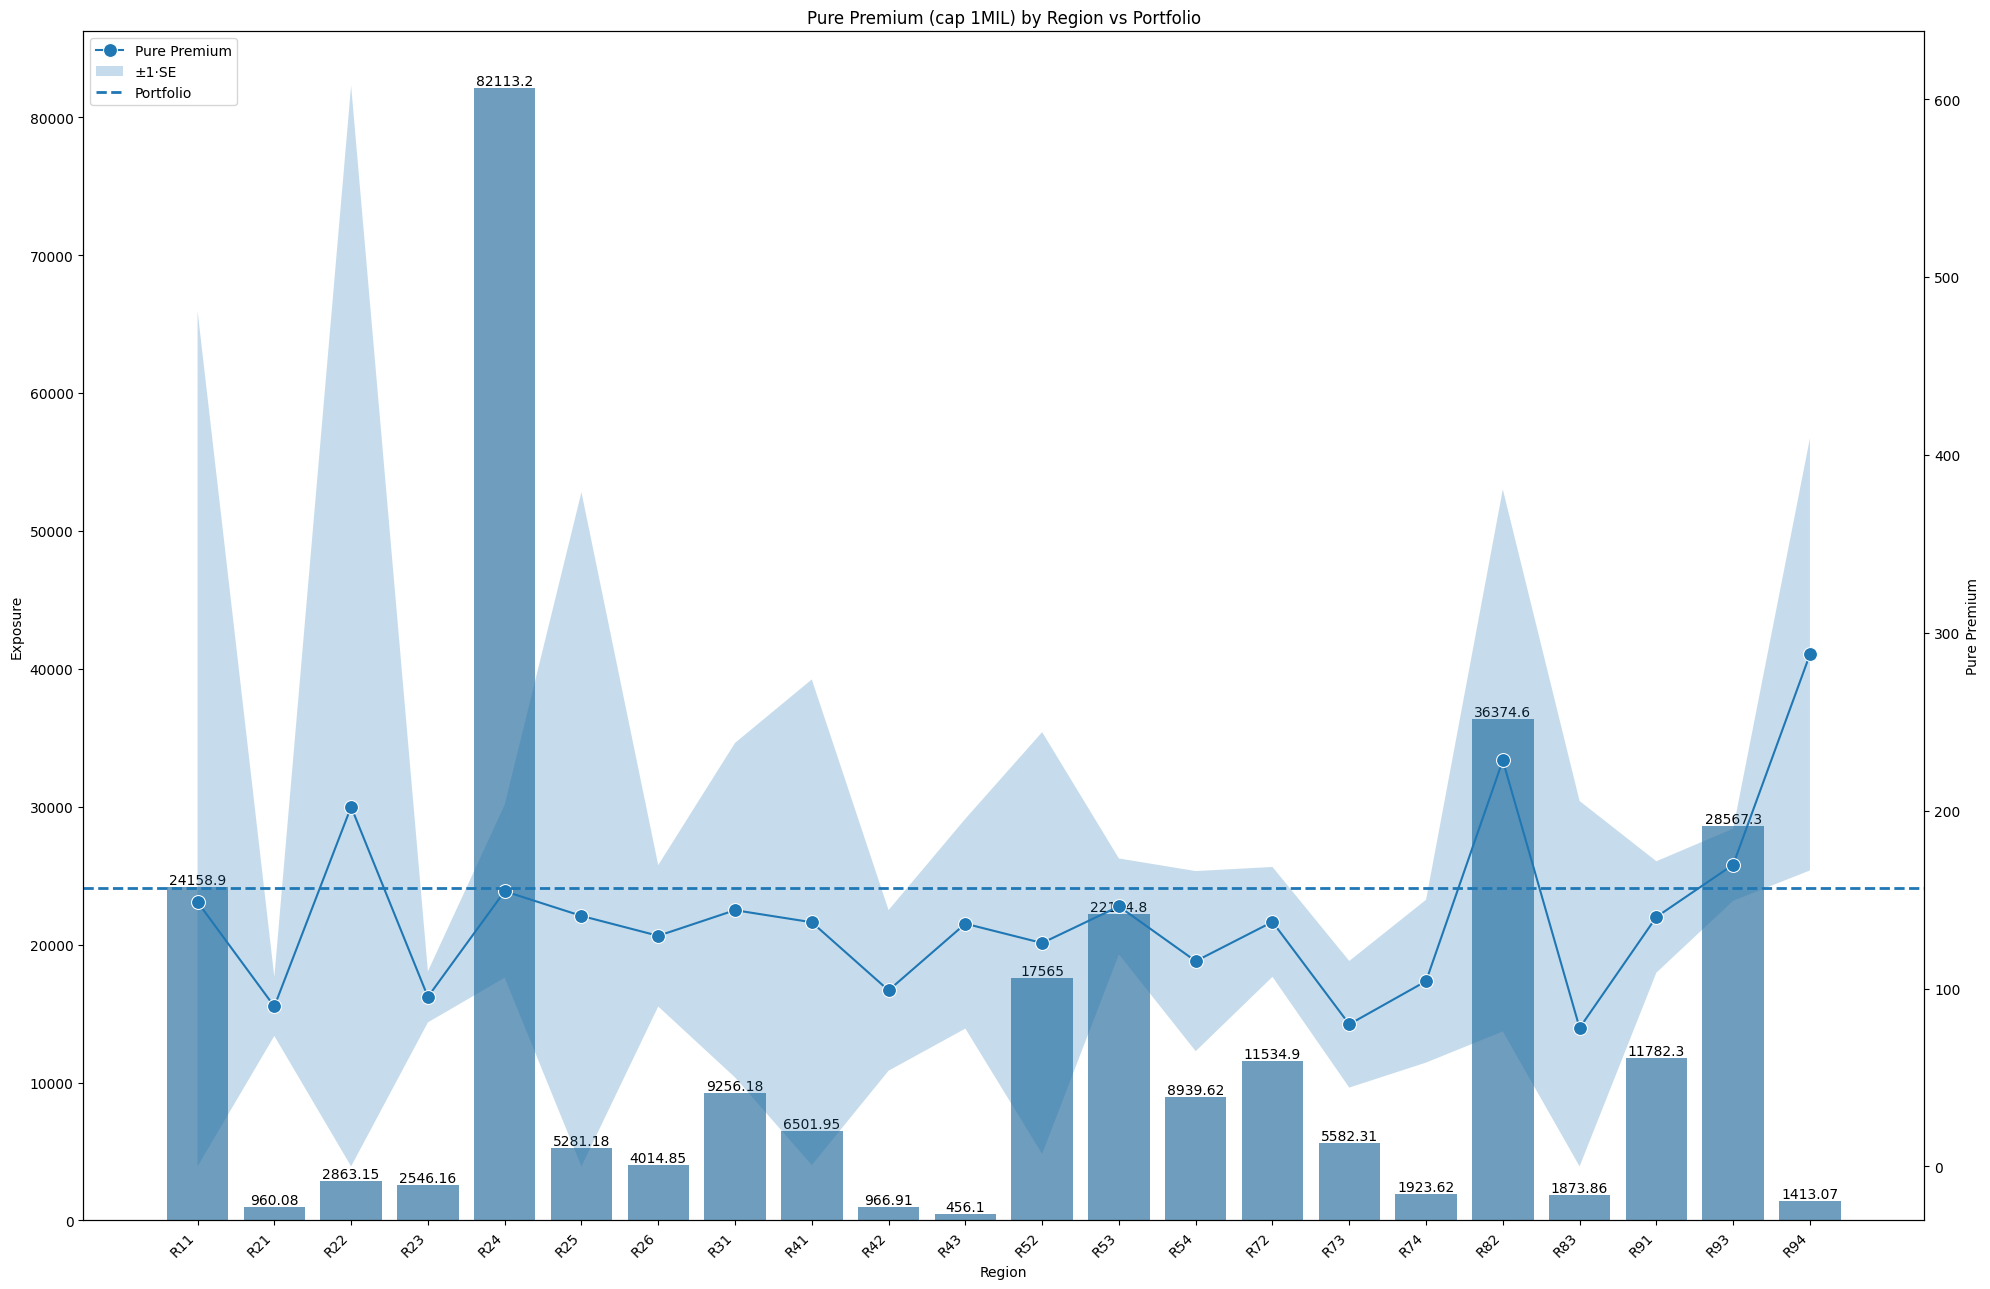

In [13]:
fig = runmultiplot(df, "Region", metric="Pure Premium", cap=1000000)

This, like VehBrand, is going to be VERY challenging to group up.

"Region" here implies a geographical definition but I can't tell from the names what these regions are. I would argue that defining a grouping based on geographical proximity or some urban vs rural grouping would be better, but I'm just not sure. I also am not sure if Area and Region are related. Let me check:

In [14]:
df["Area_Region"] = df["Area"].astype(str) + " " + df["Region"].astype(str)

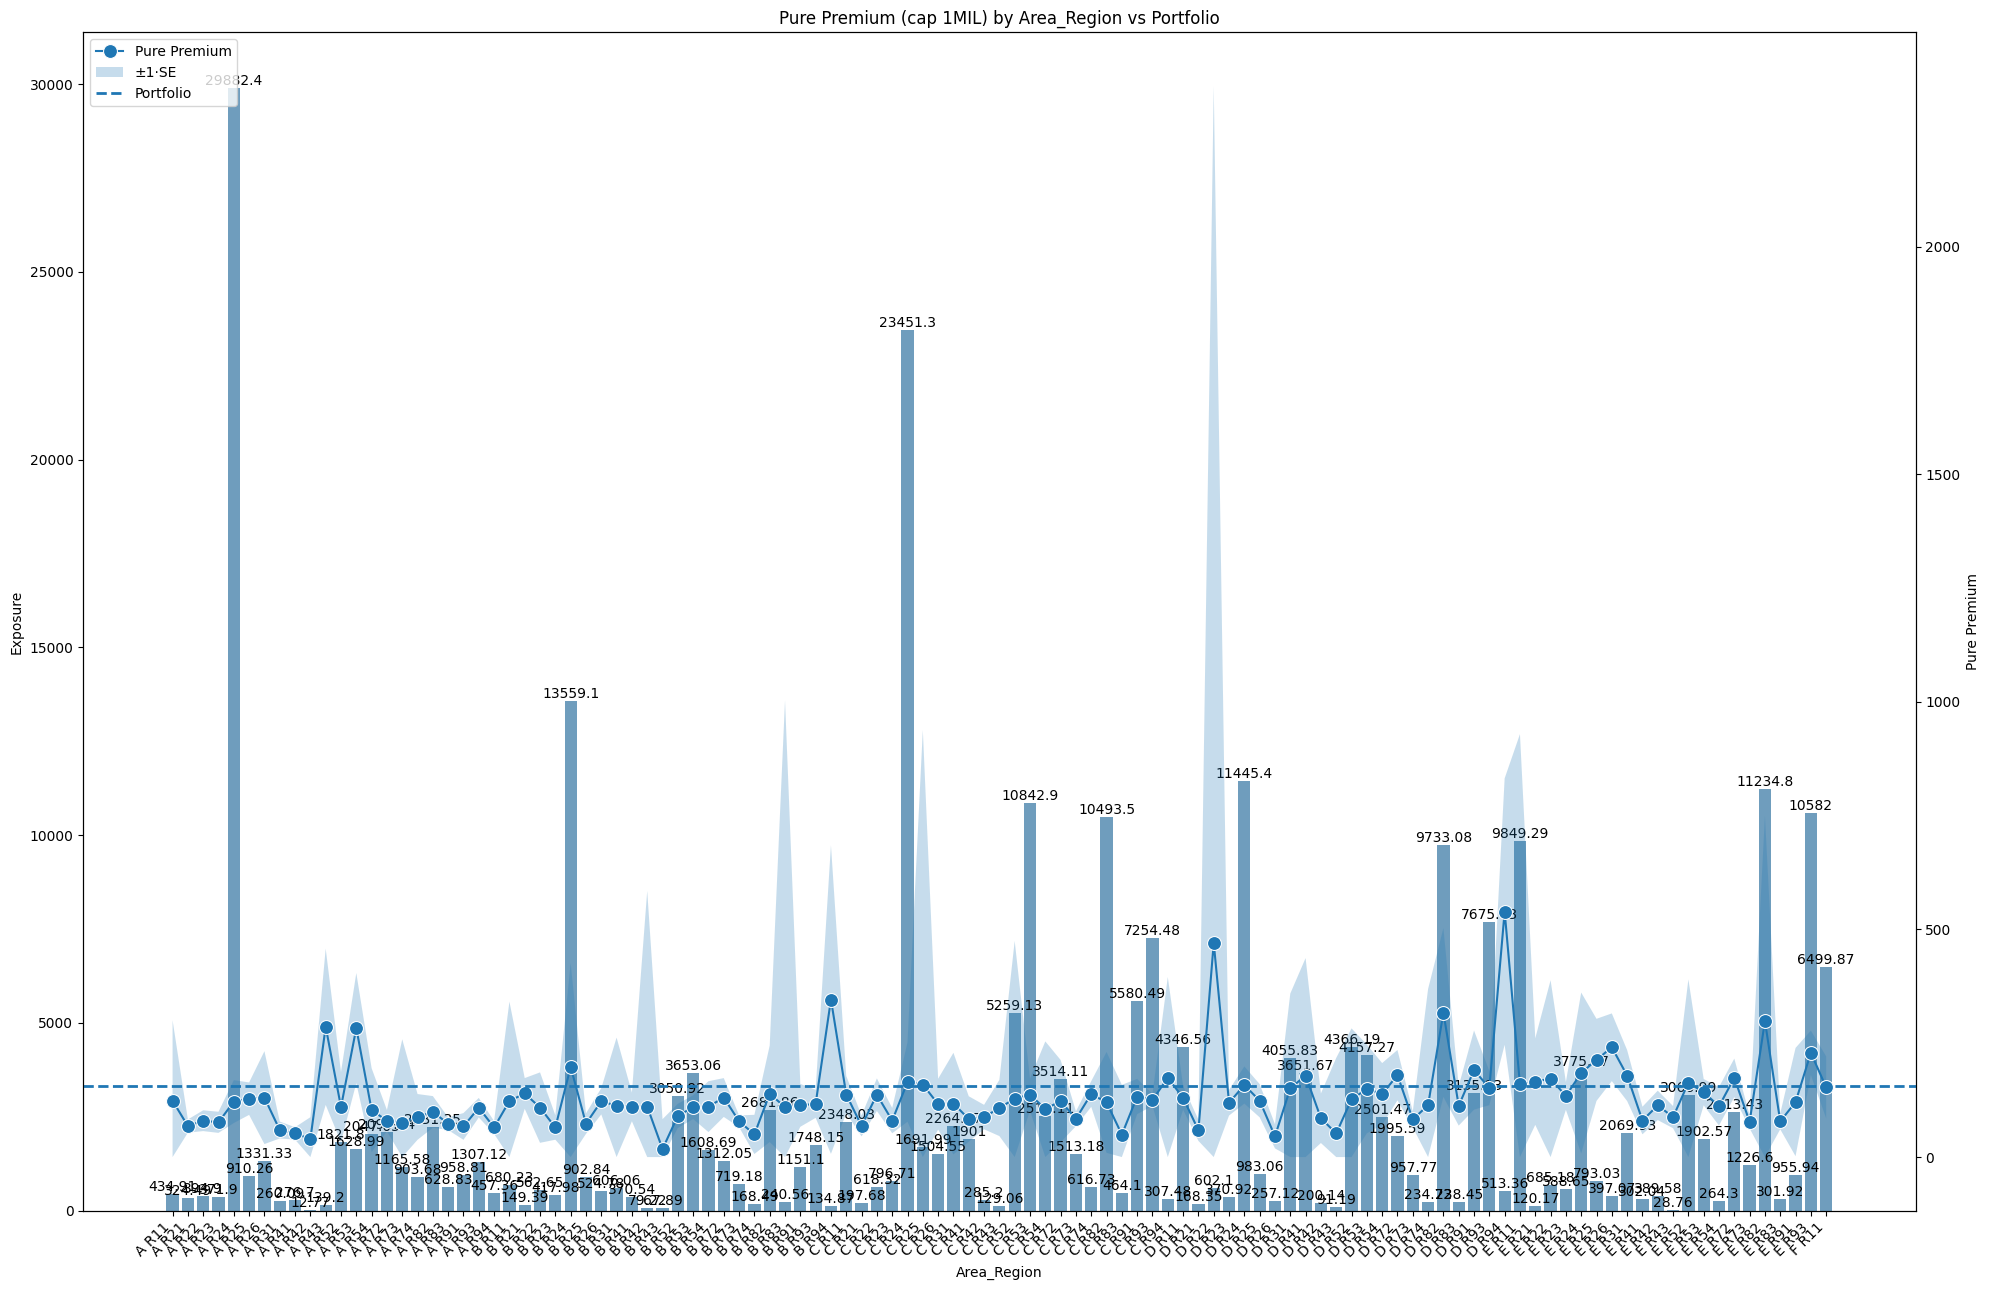

In [15]:
fig = runmultiplot(df, "Area_Region", metric="Pure Premium", cap=1000000)

Okay well I see that Regions and Areas overlap, so at least now I know that I don't need to do groupings where I combine the fields. 

Again, having more domain-specific knowledge here about these geographical fields would be HUGELY helpful. 

But since I don't have that information, I'll handle this similarly to the VehBrand approach:

In [16]:
tot_exposure = df["Exposure"].sum()
summary = df.groupby("Region", as_index=False, observed=False).agg(
  exposure = ("Exposure", "sum"),
  loss = ("ClaimAmount_capped_1MIL", "sum"),
  n = ("Region", "size")
)
summary["perc_exposure"] = summary["exposure"] / tot_exposure
summary["pure_premium"] = summary["loss"] / summary["exposure"] 
summary = summary[["Region", "perc_exposure", "pure_premium"]].sort_values("pure_premium").reset_index(drop=True)
summary

,Region,perc_exposure,pure_premium
0,R83,0.006532,77.873539
1,R73,0.019460,79.900235
2,R21,0.003347,89.912518
3,R23,0.008876,95.313068
4,R42,0.003371,98.955663
5,R74,0.006706,104.129163
6,R54,0.031164,115.397075
7,R52,0.061232,125.585293
8,R26,0.013996,129.634669
9,R43,0.001590,136.447555


I'll try this grouping:

In [17]:
df["Region_bin1"] = np.select(
  condlist=[
    df["Region"].isin(["R83","R73","R21","R23","R42","R74"]),
    df["Region"].isin(["R54"]),
    df["Region"].isin(["R52","R26"]),
    df["Region"].isin(["R43","R41","R72"]),
    df["Region"].isin(["R91","R25"]),
    df["Region"].isin(["R31"]),
    df["Region"].isin(["R53"]),
    df["Region"].isin(["R11"]),
    df["Region"].isin(["R24"]),
    df["Region"].isin(["R93"]),
    df["Region"].isin(["R22","R82","R94"]),
  ],
  choicelist=[
  "(01): R83, R73, R21, R23, R42, R74",
  "(02): R54",
  "(03): R52, R26",
  "(04): R43, R41, R72",
  "(05): R91, R25",
  "(06): R31",
  "(07): R53",
  "(08): R11",
  "(09): R24",
  "(10): R93",
  "(11): R22, R82, R94"
  ],
  default=df["Region"]
)

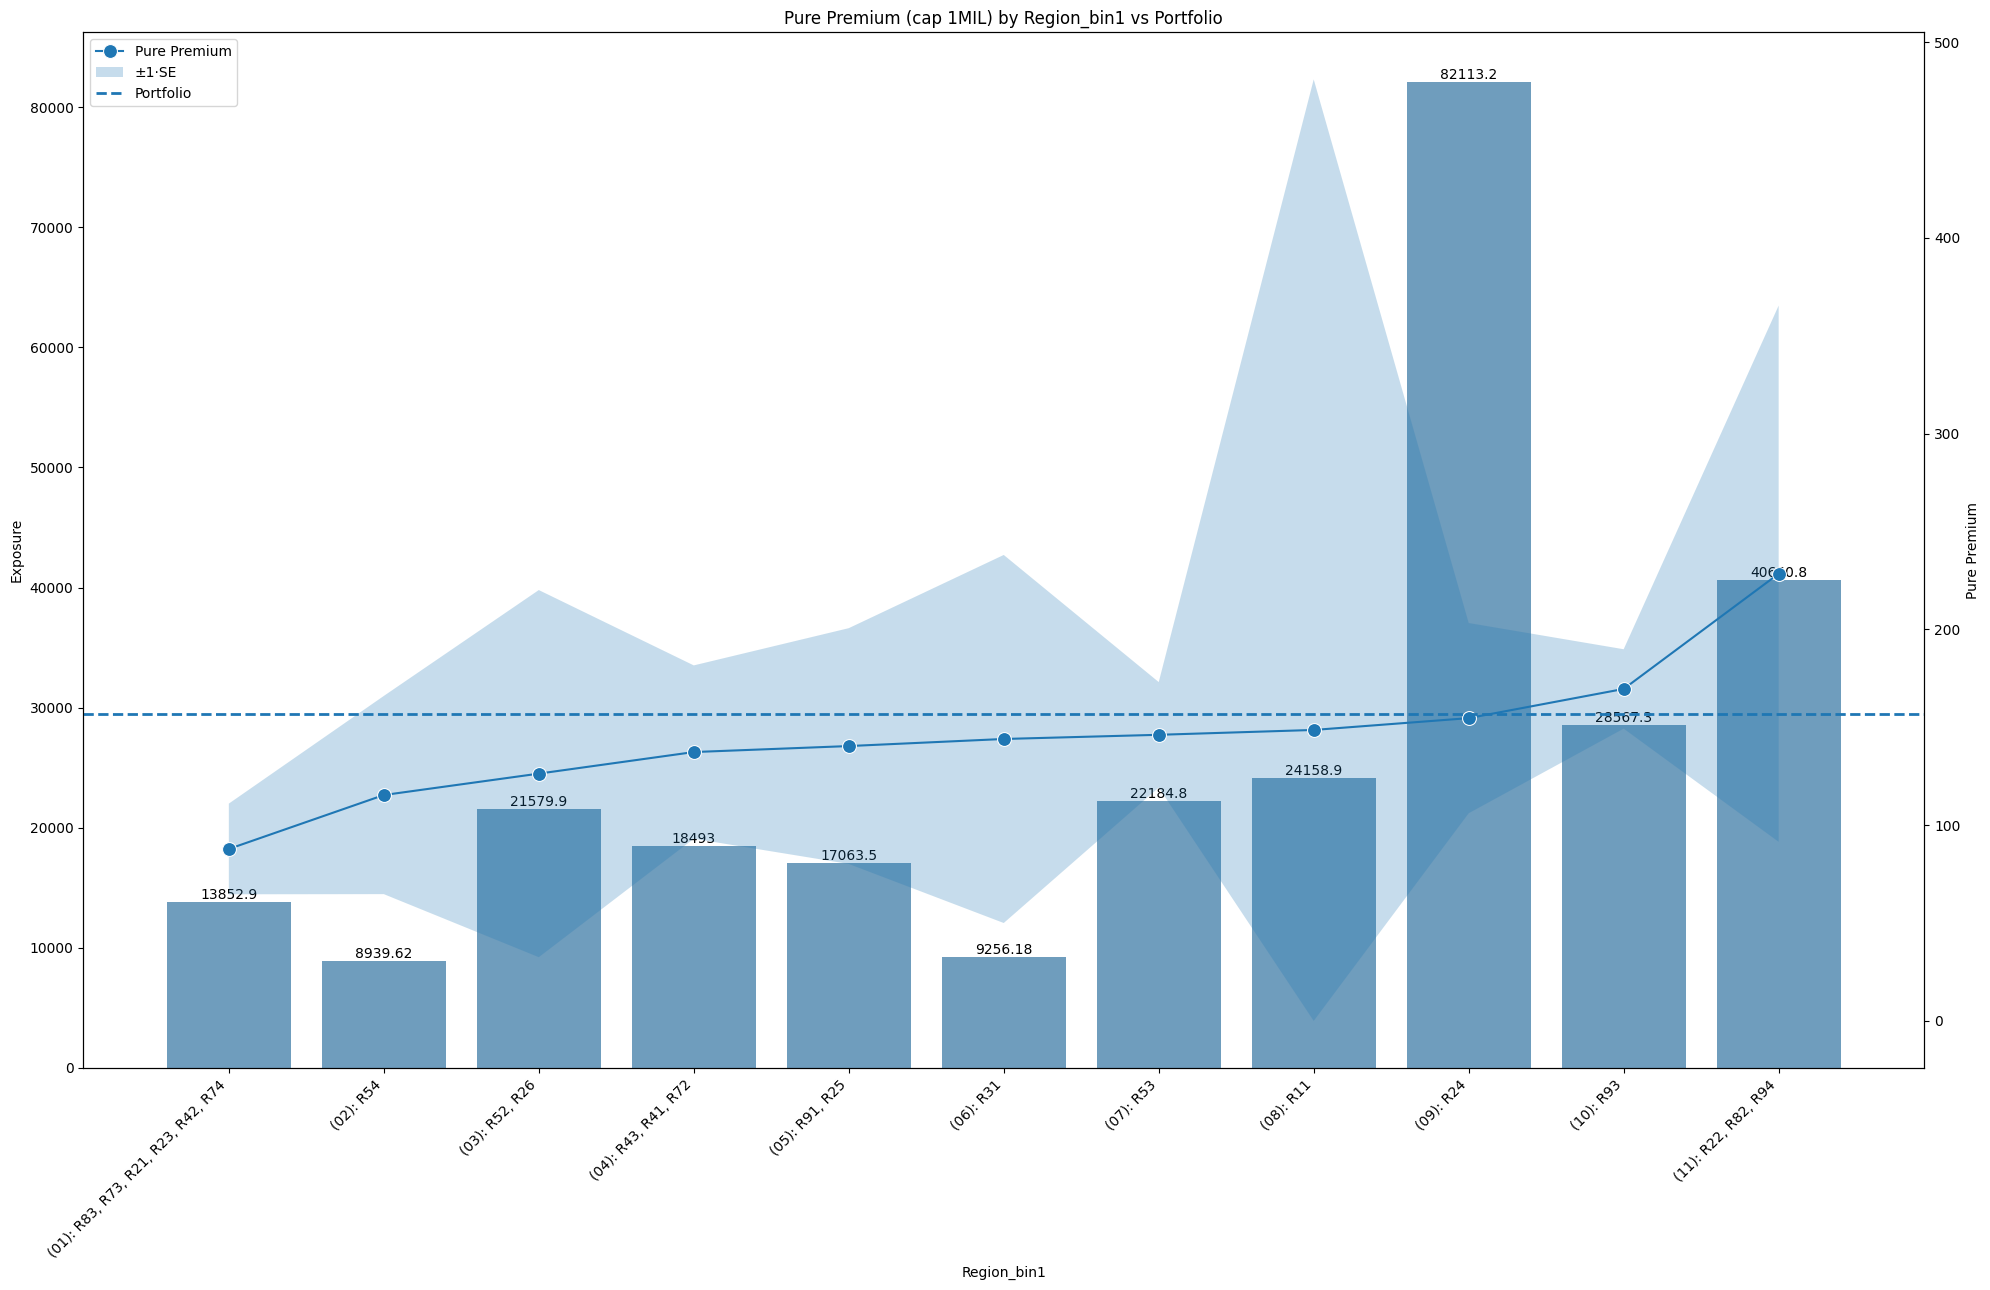

In [18]:
fig = runmultiplot(df, "Region_bin1", metric="Pure Premium", cap=1000000)

Decent enough. There's still a lot of groups, but this is much better. There's some argument I could get even more collapsed. But for now, I'll leave it here.

# Export Data

In [19]:
df.to_parquet("data/df_train_final.parquet")

# Conclusions

Great. Now I have some binned-up categorical features to use in modeling to avoid some overfitting and uncredible categories.

I am FINALLY ready to model!